---



## 9. Solutions

Open after you try Section 8.

### Solution 8.1

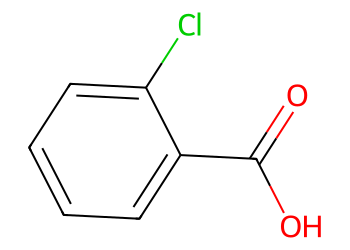

rings: <rdkit.rdBase._vectclass std::vector<int,class std::allocator<int> > object at 0x00000202F0BEB2C0>
bond 0 0 - 1 order 2
bond 1 1 - 2 order 1
bond 2 1 - 3 order 1
bond 3 3 - 4 order 1
bond 4 4 - 5 order 1
bond 5 5 - 6 order 1
bond 6 6 - 7 order 1
bond 7 7 - 8 order 1
bond 8 8 - 9 order 1
bond 9 8 - 3 order 1


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

smi = "O=C(O)c1ccccc1Cl"

mol = Chem.MolFromSmiles(smi)
display(Draw.MolToImage(mol, size=(350, 250), includeAtomNumbers=True))

num_rings = Chem.GetSSSR(mol)
print("rings:", num_rings)

for b in mol.GetBonds():
    print("bond", b.GetIdx(), b.GetBeginAtomIdx(), "-", b.GetEndAtomIdx(), "order", int(b.GetBondTypeAsDouble()))

### Solution 8.2

In [2]:
import pandas as pd
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors

names = ["Cn1cnc2N(C)C(=O)N(C)C(=O)c12", "CC(=O)Nc1ccc(O)cc1", "CC(C)Cc1ccc(cc1)C(C)C(O)=O"]
rows = []
for nm in names:
    m = Chem.MolFromSmiles(nm)
    rows.append({
        "smiles": nm,
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "HBD": rdMolDescriptors.CalcNumHBD(m),
        "HBA": rdMolDescriptors.CalcNumHBA(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m)
    })

pd.DataFrame(rows)

,smiles,MolWt,LogP,HBD,HBA,TPSA
0,Cn1cnc2N(C)C(=O)N(C)C(=O)c12,194.194,-1.0293,0,6,61.82
1,CC(=O)Nc1ccc(O)cc1,151.165,1.3506,2,2,49.33
2,CC(C)Cc1ccc(cc1)C(C)C(O)=O,206.285,3.0732,1,1,37.30


### Solution 8.3

O=C(O)c1ccc(F)cc1


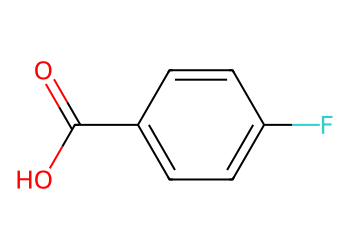

In [3]:
find = Chem.MolFromSmiles("Cl")
put  = Chem.MolFromSmiles("F")
mol  = Chem.MolFromSmiles("Clc1ccc(cc1)C(=O)O")
out  = Chem.ReplaceSubstructs(mol, find, put, replaceAll=True)[0]
print(Chem.MolToSmiles(out))
Draw.MolToImage(out, size=(350, 250))

### Solution 8.4

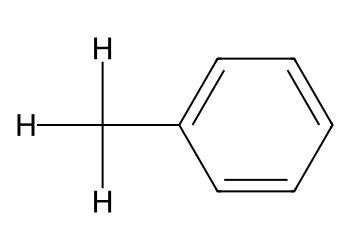

In [4]:
mol = Chem.MolFromSmiles("c1ccccc1")
em = Chem.EditableMol(mol)

idx_C = em.AddAtom(Chem.Atom("C"))
idx_H1 = em.AddAtom(Chem.Atom("H"))
idx_H2 = em.AddAtom(Chem.Atom("H"))
idx_H3 = em.AddAtom(Chem.Atom("H"))

em.AddBond(2, idx_C, order=Chem.BondType.SINGLE)
em.AddBond(idx_C, idx_H1, order=Chem.BondType.SINGLE)
em.AddBond(idx_C, idx_H2, order=Chem.BondType.SINGLE)
em.AddBond(idx_C, idx_H3, order=Chem.BondType.SINGLE)

mol2 = em.GetMol()
Chem.SanitizeMol(mol2)
Draw.MolToImage(mol2, size=(350, 250), includeAtomNumbers=True)

### Solution 8.5

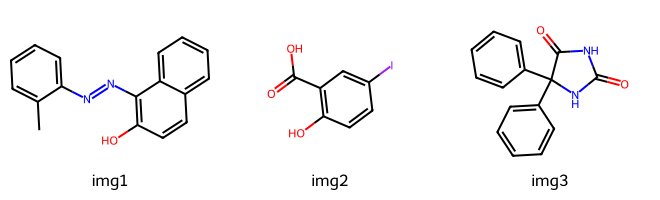

In [5]:
# Paste the SMILES you obtained from PubChem Draw structure
smi1 = "CC1=CC=CC=C1N=NC2=C(C=CC3=CC=CC=C32)O"  # for image 1
smi2 = "C1=CC(=C(C=C1I)C(=O)O)O"  # for image 2
smi3 = "C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3"  # for image 3

m1 = Chem.MolFromSmiles(smi1)
m2 = Chem.MolFromSmiles(smi2)
m3 = Chem.MolFromSmiles(smi3)

Draw.MolsToGridImage([m1, m2, m3], legends=["img1","img2","img3"], molsPerRow=3, subImgSize=(220,200), useSVG=True)

In [6]:
# Compute quick properties for the three molecules
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
import pandas as pd

def props(m):
    return dict(
        MolWt=Descriptors.MolWt(m),
        LogP=Crippen.MolLogP(m),
        HBD=rdMolDescriptors.CalcNumHBD(m),
        HBA=rdMolDescriptors.CalcNumHBA(m),
        TPSA=rdMolDescriptors.CalcTPSA(m)
    )

df = pd.DataFrame([
    {"name":"img1","smiles":smi1, **props(m1)},
    {"name":"img2","smiles":smi2, **props(m2)},
    {"name":"img3","smiles":smi3, **props(m3)}
]).round(3)

df

,name,smiles,MolWt,LogP,HBD,HBA,TPSA
0,img1,CC1=CC=CC=C1N=NC2=C(C=CC3=CC=CC=C32)O,262.312,5.269,1,3,44.95
1,img2,C1=CC(=C(C=C1I)C(=O)O)O,264.018,1.695,2,2,57.53
2,img3,C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3,252.273,1.770,2,2,58.20


## 10. In-class activity


### 10.1 Linear Regression with two features

Use only `MolWt` and `TPSA` to predict **Melting Point** with Linear Regression. Use a 90/10 split and report **MSE**, **MAE**, and **R²**.

```python

# Q1 starter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = df_reg_mp[["MolWt", "TPSA"]]
y = df_reg_mp["Melting Point"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=0
)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"R2:  {r2_score(y_test, y_pred):.3f}")
```

### 10.2 Ridge across splits

Train a Ridge model (`alpha=1.0`) for **Melting Point** using `MolWt, LogP, TPSA, NumRings`. Compare test **R²** for train sizes 60, 70, 80, 90 percent with `random_state=42`. Plot **R²** vs train percent.

```python
X = df_reg_mp[["MolWt", "LogP", "TPSA", "NumRings"]].values
y = df_reg_mp["Melting Point"].values

splits = [0.4, 0.3, 0.2, 0.1]  # corresponds to 60/40, 70/30, 80/20, 90/10
r2_scores = []

for t in splits:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=t, random_state=42
    )
    model = Ridge(alpha=1.0).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))

# Plot results
plt.figure(figsize=(6,4))
plt.plot([60,70,80,90], r2_scores, "o-", lw=2)
plt.xlabel("Train %")
plt.ylabel("R² (test)")
plt.title("Effect of train/test split on Ridge Regression accuracy")
plt.show()
```

### 10.3 pKa regression two ways

Build Ridge regression for **pKa** and for **exp(pKa)** using the same four descriptors. Report **R²** and **MSE** for each.

```python

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Keep rows with a valid pKa
df_pka = df[["MolWt", "LogP", "TPSA", "NumRings", "pKa"]].dropna()

X = df_pka[["MolWt", "LogP", "TPSA", "NumRings"]].values
y = df_pka["pKa"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

model = Ridge(alpha=1.0).fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Test R2:  {r2_score(y_test, y_pred):.3f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.3f}")

# Parity plot
plt.figure(figsize=(5,4))
plt.scatter(y_test, y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True pKa")
plt.ylabel("Predicted pKa")
plt.title("Parity plot for pKa regression (Ridge)")
plt.show()
```

### 10.4 pKa to classification

Turn **pKa** into a binary label and train Logistic Regression with the same descriptors. Report Accuracy, Precision, Recall, F1, and AUC, and draw the ROC. You may pick either rule.

- Option A: acidic if pKa ≤ 7  
- Option B: median split on pKa

```python

# Clean pKa subset
df_pka = df[["MolWt", "LogP", "TPSA", "NumRings", "pKa"]].dropna()
X = df_pka[["MolWt", "LogP", "TPSA", "NumRings"]].values
pka_vals = df_pka["pKa"].values

# ---- Helper to run classification and plot ----
def run_classification(y_cls, rule_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cls, test_size=0.20, random_state=42, stratify=y_cls
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_proba)

    print(f"--- {rule_name} ---")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1:        {f1:.3f}")
    print(f"AUC:       {auc:.3f}")
    print()

    # ROC plot
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for pKa classification ({rule_name})")
    plt.legend()
    plt.show()

# ---- Rule A: acidic if pKa ≤ 7 ----
y_cls_A = (pka_vals <= 7.0).astype(int)
run_classification(y_cls_A, "Rule A (pKa ≤ 7 = acidic)")

# ---- Rule B: median split ----
median_val = np.median(pka_vals)
y_cls_B = (pka_vals <= median_val).astype(int)
run_classification(y_cls_B, f"Rule B (≤ median pKa = acidic, median={median_val:.2f})")
```

### 10.5 Threshold tuning on toxicity

Using the toxicity classifier from Section 5, scan thresholds `0.2` to `0.8` in steps of `0.05`. Find the smallest threshold with **recall ≥ 0.80** and report the corresponding **precision** and **F1**. Plot the metric curves vs threshold.

```python
# Starter
ths = np.arange(0.20, 0.81, 0.05)
rec_list, prec_list, f1_list = [], [], []
best_t = None

for t in ths:
    pred_t = (y_proba >= t).astype(int)
    r = recall_score(y_test, pred_t)
    p = precision_score(y_test, pred_t, zero_division=0)
    f = f1_score(y_test, pred_t, zero_division=0)
    rec_list.append(r); prec_list.append(p); f1_list.append(f)
    if best_t is None and r >= 0.80:
        best_t = t

print("First threshold with recall >= 0.80:", best_t)

plt.figure(figsize=(7,5))
plt.plot(ths, rec_list, marker="o", label="Recall")
plt.plot(ths, prec_list, marker="o", label="Precision")
plt.plot(ths, f1_list, marker="o", label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold tuning on toxicity")
plt.legend()
plt.grid(True)
plt.show()
```